# Training
Here we show how to process a new image with the Hierarchical Bayesian Model (HBM) for bland pixel identification and mineral classification. To run this tutorial you need to have the MAT files from the [CRISM ML datasets](https://zenodo.org/records/13338091) web page in the `datasets` directory. They are automatically downloaded by the tutorial.

We define some paths and download an image from the CRISM database. 
To get the links of another CRISM image, go to the [CRISM map](http://crism-map.jhuapl.edu/) and search the last 5 digits of the image id, then select either the link for the S or L sensor and in the page that opens select "*IR image data*"; in the image page, the first two links are the `.img` and `.lbl` files. Here we copied the links for the image `16CFE`.
The images do not have radiometric and atmospheric corrections; for that, you will need the [CRISM Analysis Toolkit (CAT)](https://pds-geosciences.wustl.edu/missions/mro/crism.htm).

In [1]:
# some useful settings when experimenting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import logging
logging.basicConfig(level=logging.INFO)

import os
import urllib.request

DATA_URL = "https://zenodo.org/records/13338091/files/"
CRISM_URL = "https://pds-geosciences.wustl.edu/mro/mro-m-crism-3-rdr-"\
            "targeted-v1/mrocr_2104/trdr/2010/2010_056/hrl00016cfe/"\
            "hrl00016cfe_07_if181l_trr3"

WORKDIR = "../workdir"
IMAGES = "../image_hdrs"
DATADIR = "../datasets"
os.makedirs(WORKDIR, exist_ok=True)
os.makedirs(IMAGES, exist_ok=True)
os.makedirs(DATADIR, exist_ok=True)

# download dataset
datapath = os.path.join(DATADIR, "CRISM_bland_unratioed.mat")
if not os.path.isfile(datapath):
    urllib.request.urlretrieve(
        f"{DATA_URL}/CRISM_bland_unratioed.mat", datapath)
    
datapath = os.path.join(DATADIR, "CRISM_labeled_pixels_ratioed.mat")
if not os.path.isfile(datapath):
    urllib.request.urlretrieve(
        f"{DATA_URL}/CRISM_labeled_pixels_ratioed.mat", datapath)

# download image
im_name = os.path.basename(CRISM_URL)

im_path = os.path.join(IMAGES, f"{im_name}.lbl")
if not os.path.isfile(im_path):
    urllib.request.urlretrieve(f"{CRISM_URL}.lbl", im_path)
    
im_path = os.path.join(IMAGES, f"{im_name}.img")
if not os.path.isfile(im_path):
    urllib.request.urlretrieve(f"{CRISM_URL}.img", im_path)

We now load the models. The function needs a set of feature indices, to select the right features for each model in the ensemble; we also load the ensemble weights needed for inference later on. The weights accept a list of classes, to only load the weights for the classes actually in the dataset.

The training functions load internally the datasets from the `DATADIR` directory, preprocess them and train the models. Dataset processing and training may take ~2-3 minutes. The preprocessed datasets and trained models are cached, and thus the next time you call the training functions they will be very fast.
If you want to disable caching, you need to set `USE_CACHE=False` in `crism_ml/__init__.py` (the package initialization module).

In [2]:
%%time
from crism_ml.train import feat_masks, train_model_bland, train_model, \
    iteration_weights

fin0, fin = feat_masks()
bmodels = train_model_bland(DATADIR, fin0)
models = train_model(DATADIR, fin)
ww_ = iteration_weights(models[0].classes)

INFO:root:Loading from cache: c:\dev\crism\crism_ml\.cache\default_bmodel.pkl
INFO:root:Loading from cache: c:\dev\crism\crism_ml\.cache\default_model.pkl


Wall time: 204 ms


The next step is to load the image and pre-process it. Loading is handled by a specific `load_image` function, supporting Matlab files or CRISM ENVI images. ENVI images are loaded if the data (`.img`) and the header (`.hdr`) are present. The header is often missing in CRISM, but the label (`.lbl`) file contains enough information to reconstruct it; the image loader automatically generates the header file if missing. The image loader uses the `spectral` library under the hood.

The next step is to remove bad pixels, defined as pixels where at least a channel has NaN or infinite values, or a value larger than 1000. CRISM uses 65535 as conventional "invalid" value, and thus this step removes all the invalid pixels. The invalid values are replaced with the mean over all the pixels and channels.

In [3]:
from crism_ml.io import load_image
from crism_ml.preprocessing import filter_bad_pixels

mat = load_image(im_path)
if_, rem = filter_bad_pixels(mat['IF'])

INFO:root:10254 bad pixels


This shows the image in false colors. We need first to reshape the array of spectra and the mask of bad pixels as images using `image_shape` to get the correct shape. The RGB channels are equalized before visualization.

(-0.5, 319.5, 419.5, -0.5)

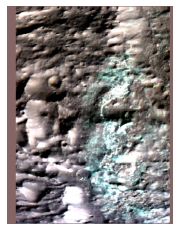

In [4]:
import matplotlib.pyplot as plt
from crism_ml.io import image_shape
from crism_ml.plot import get_false_colors

im_shape = image_shape(mat)
im_fc = get_false_colors(if_.reshape(*im_shape, -1),
                         rem.reshape(im_shape))
plt.imshow(im_fc)
plt.axis("off")

Before classification, the pixels are ratioed, that is, divided by the spectra of a homogeneous region in the same column to account for systematic sources of signal distortion. The pixels are identified with the help of the bland pixel classifier, which gives a score to each pixel and selects the 3 pixels with the highest score. The bad pixels are encoded by a bland score of $-\infty$, that is, they will never be selected.

Before ratioing, spikes are removed from the spectra. A spike is a channel value that deviates from the median in a window of size 3 by more than 5 standard deviations, computed on the column. For both spike removal and ratioing we reshape the image to let the functions access column information.

The bland scores are computed by the function `compute_bland_scores` taking the models as input. The function applies L2 normalization and the feature masks before evaluating the bland model(s).

In [5]:
%%time
import numpy as np
from crism_ml.preprocessing import remove_spikes_column, replace, ratio
from crism_ml.train import compute_bland_scores

if1 = remove_spikes_column(
    if_.reshape(*im_shape, -1), 3, 5).reshape(if_.shape)
slog = compute_bland_scores(if1, (bmodels, fin0))

slog_inf = replace(slog, rem, -np.inf).reshape(im_shape)
if2 = ratio(if1.reshape(*im_shape, -1), slog_inf).reshape(if_.shape)

Wall time: 1.48 s


Another spike removal pass, this time using the statistics over all the image. Differently from before, it is now performed in three passes, with window size of 11, 7 and 3, to prevent the removal of valid spectral features. We pass a copy of the ratioed data because the function performs the operation in-place to save memory.

Then, we compute the mineral classification scores. The function applies min-max normalization, i.e. setting the range between 0 and 1 for each feature, and applies feature masks and model weigths. An ensemble is automatically parallelized to save time.

In [6]:
%%time
from crism_ml.preprocessing import remove_spikes
from crism_ml.train import compute_scores

ifm = remove_spikes(if2.copy())
sumlog = compute_scores(ifm, (models, fin), ww_)

Wall time: 11.3 s


Now it's time to filter and clean the predictions. The first step is to select only the predictions with confidence larger than a threshold: here, classes with at least 5 images in the dataset use a threshold of 0.5, and 0.7 otherwise. The function returns also the raw predictions `pred0` and the confidences `pp_` for further processing.

The function `evaluate_regions` selects the connected components in a class prediction with size that exceed a (per-class) theshold, set by default to 5. The regions are returned as a list of dictionaries with summary information such as size, average spectrum, pixels coordinates and so on; see the function documentation for more details. The function `merge_regions` merges connected components belonging to the same class and also to similar minerals: for examples, *beidellite* and *montmorillonite* are considered instances of *Al smectites*. The full list of class codes and names is available in `crism_ml.lab.BROAD_NAMES`.

The regions may be passed to a plot function to show a prediction map overlaid on the image; we show the predictions before filtering and after region evaluation to show the difference. The visualization function limits the maximum number of visualized classes to 15 to reduce clutter.

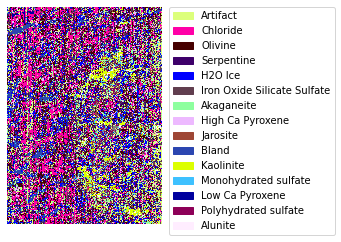

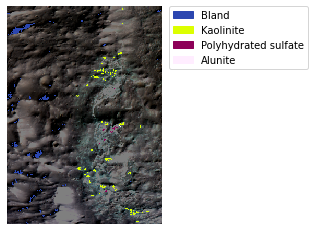

In [7]:
from crism_ml.train import filter_predictions, evaluate_regions, merge_regions
from crism_ml.preprocessing import crop_region
from crism_ml.plot import show_classes

pred, pred0, pp_ = filter_predictions(sumlog, models[0].classes,
                                      kls_thr=(0.5, 0.7))
avgs = evaluate_regions(if2, im_shape, replace(pred, rem, 0), pp_, if0=if_)
regs = merge_regions(avgs)

crop = crop_region(rem.reshape(im_shape))
show_classes(im_fc/2, pred0, crop_to=crop)
show_classes(im_fc/2, regs, crop_to=crop)

You can tweak the evaluation parameters to select different regions. Here we double the size threshold and we remove the dilation step in finding connected components, i.e. now all the pixels in the patch needs to be directly connected.
The small kaolinite and alunite outcrops have now disappeared from the map.

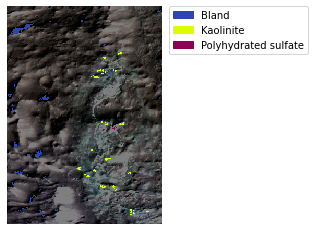

In [8]:
regions = lambda classes: np.full(len(classes), 10)   # set size threshold to 3
avgs_new = evaluate_regions(
    if2, im_shape, replace(pred, rem, 0), pp_, region_size=regions, dilate=0)

show_classes(im_fc/2, merge_regions(avgs_new), crop_to=crop)

Here we show the unratioed (green) and ratioed (red) average spectrum over all the image for the kaolinite detections (class 15). The effect of ratioing is significant, as it mostly erased the big 2$\mu$m feature due to atmospheric contamination, as in this example we didn't apply any kind of advanced radiometric and photometric correction.

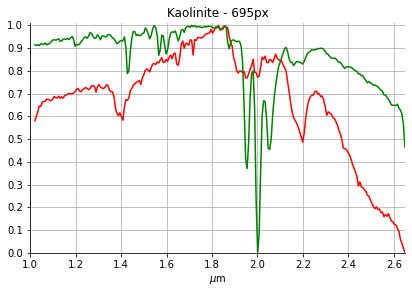

In [9]:
from crism_ml.train import merge_regions
from crism_ml.plot import plot_spectra

# convert the list to a class-region dictionary and access kaolinite
kaol_reg = {r['pred']: r for r in regs}[15]
title = f"Kaolinite - {kaol_reg['size']}px"
plot_spectra(kaol_reg['avg'], None, kaol_reg['avg0'], {'title': title})

You can also plot the individual patches: here we show the first region, a small alunite outcrop, with the unratioed (green) and ratioed (red) average spectrum. Passing the patch coordinates to `get_overlay` generates a red overlay on the original image, shown on the left side. The region is dilated with a morphological operator to make it more easy to spot:

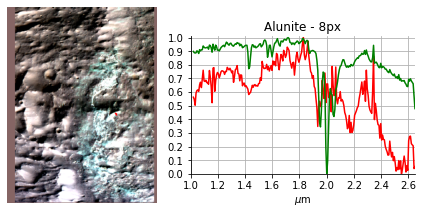

In [10]:
from crism_ml.lab import BROAD_NAMES
from crism_ml.plot import get_overlay

title = f"{BROAD_NAMES[avgs[0]['pred']]} - {avgs[0]['size']}px"
plot_spectra(avgs[0]['avg'], None, avgs[0]['avg0'],
             {'title': title}, overlay=get_overlay(im_fc, avgs[0]['coords']))